In [36]:
import numpy
from astropy.io import fits
import os
%matplotlib notebook
from matplotlib import pyplot
import bokeh.plotting as bplot
bplot.output_notebook()

BokehJS successfully loaded.

In [8]:
from aotools.circle import zernike
from soapy import atmosphere, confParse

In [9]:
SOAPY_CONF = "conf/test_conf.py"

In [141]:
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()

config.atmos.wholeScrnSize = 4096
config.atmos.scrnNo = 1

NZERNS = 30
NR0s = 10
NIters = 5000
RUNS = 5
R0s = numpy.linspace(0.05, 0.5, NR0s)

print("Telescope Diameters:{}".format(config.tel.telDiam))

Telescope Diameters:8.0


In [142]:
# Make the zernike to use in advance
Zs = zernike.zernikeArray(NZERNS+1, config.sim.pupilSize)
piston = Zs[0]
Zs = Zs[1:]
Zs.shape = NZERNS, config.sim.pupilSize**2

In [143]:
# Test the large screen travelling over the telescope
# Buffer to store zernike coeffs
zCoeffs = numpy.zeros((NR0s, NIters*RUNS, NZERNS))

sCoord = int(round((config.sim.scrnSize-config.sim.pupilSize)/2)) # Coordinate to get middle of phase screen
for ir0, r0 in enumerate(R0s):
    print("Do Run with r0: {}".format(r0))
    config.atmos.r0 = r0
    for irun in range(RUNS):
        atmos = atmosphere.atmos(config.sim, config.atmos)
        for i in range(NIters):
            scrn = atmos.moveScrns()[0]
            subScrn = scrn[sCoord:-sCoord, sCoord:-sCoord] * (2*numpy.pi/500.)
            subScrn = subScrn.reshape(config.sim.pupilSize**2)
            # Get z coeffs
            zCoeffs[ir0, irun*NIters + i] = (Zs*subScrn).sum(1)/piston.sum()

Do Run with r0: 0.05
Do Run with r0: 0.266666666667
Do Run with r0: 0.483333333333
Do Run with r0: 0.7
Do Run with r0: 0.916666666667
Do Run with r0: 1.13333333333
Do Run with r0: 1.35
Do Run with r0: 1.56666666667
Do Run with r0: 1.78333333333
Do Run with r0: 2.0


In [144]:
zVars = zCoeffs.var(1)

In [145]:
# Load the noll reference values
noll = fits.getdata("resources/noll.fits").diagonal()[:NZERNS]

<IPython.core.display.Javascript object>


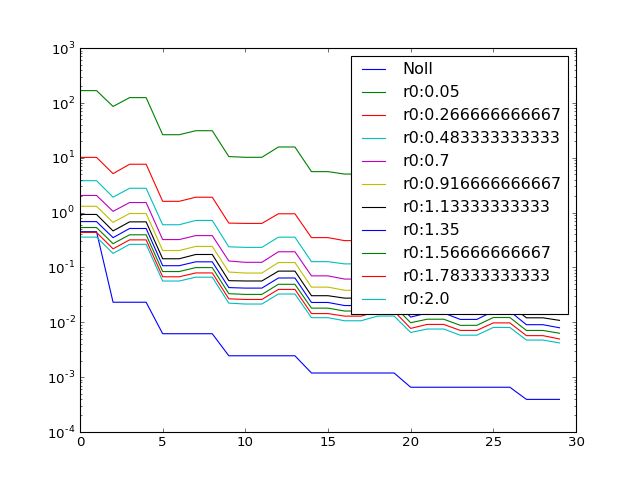

In [156]:
pyplot.figure()
pyplot.semilogy(noll, label="Noll")
for ir0, r0 in enumerate(R0s):
    pyplot.semilogy(zVars[ir0], label="r0:{}".format(r0))
pyplot.legend()

## measuredR0s = config.tel.telDiam/ ((zVars[:,2:]/noll[2:]).mean(1))**(3/5.)

In [148]:
plt = bplot.figure()
plt.line(R0s, measuredR0s, legend="Measured")
plt.line(R0s, R0s, color="k", legend="Theoretical")
bplot.show(plt)

In [149]:
zVars.shape

(10, 30)

In [150]:
zCoeffs.shape

(10, 25000, 30)

In [151]:
# Test random screen generation
# Buffer to store zernike coeffs
zCoeffs = numpy.zeros((NR0s, NIters*RUNS, NZERNS))
config.atmos.randomScrns = True
sCoord = int(round((config.sim.scrnSize-config.sim.pupilSize)/2)) # Coordinate to get middle of phase screen
for ir0, r0 in enumerate(R0s):
    print("Do Run with r0: {}".format(r0))
    config.atmos.r0 = r0
    atmos = atmosphere.atmos(config.sim, config.atmos)
    for i in range(NIters*RUNS):
        scrn = atmos.moveScrns()[0]
        subScrn = scrn[sCoord:-sCoord, sCoord:-sCoord] * (2*numpy.pi/500.)
        subScrn = subScrn.reshape(config.sim.pupilSize**2)
        # Get z coeffs
        zCoeffs[ir0, i] = (Zs*subScrn).sum(1)/piston.sum()

Do Run with r0: 0.05
Do Run with r0: 0.266666666667
Do Run with r0: 0.483333333333
Do Run with r0: 0.7
Do Run with r0: 0.916666666667
Do Run with r0: 1.13333333333
Do Run with r0: 1.35
Do Run with r0: 1.56666666667
Do Run with r0: 1.78333333333
Do Run with r0: 2.0


In [152]:
zVars = zCoeffs.var(1)

<IPython.core.display.Javascript object>


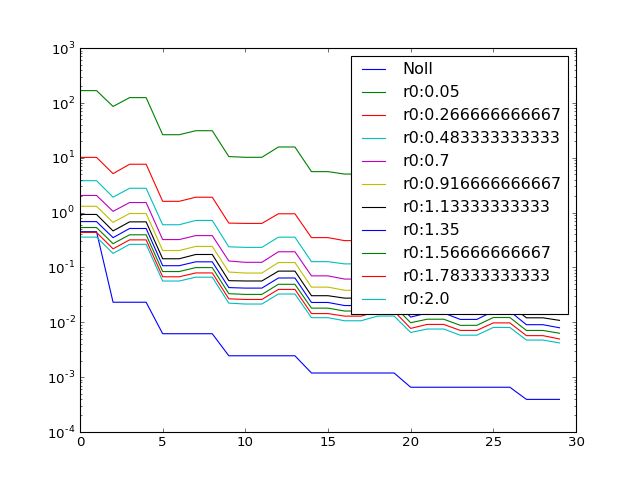

In [153]:
pyplot.figure()
pyplot.semilogy(noll, label="Noll")
for ir0, r0 in enumerate(R0s):
    pyplot.semilogy(zVars[ir0], label="r0:{}".format(r0))
pyplot.legend()

In [154]:
measuredR0s = config.tel.telDiam/ ((zVars[:,2:]/noll[2:]).mean(1))**(3/5.)

In [155]:
plt = bplot.figure()
plt.line(R0s, measuredR0s, legend="Measured")
plt.line(R0s, R0s, color="k", legend="Theoretical")
bplot.show(plt)